In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler

import joblib
import pennylane as qml
torch.manual_seed(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
train_data=pd.read_csv('./assets/processed dataset/train dataset.csv')
validation_data=pd.read_csv('./assets/processed dataset/validation dataset.csv')

In [4]:
#Data scaling
scaler=MinMaxScaler()
normalized_train_data=scaler.fit_transform(train_data)
joblib.dump(scaler, "./assets/scaler.gz") 
print(normalized_train_data[0])
normalized_validation_data=scaler.transform(validation_data)
print(normalized_validation_data[0])

[0.         0.22440945 0.2704501  0.35034305]
[0.         0.17847769 0.7592955  0.64193825]


In [5]:
#Prepearing X and Y for training and validation
# Setting THE SEQUENCE LENGTH 
seq_length=180
#initialized to a empty 1d list
X_train=[]
Y_train=[]
X_validate=[]
Y_validate=[]
for i in range(seq_length,train_data.shape[0]):
    #Data from 0 to 59TH index
    X_train.append(normalized_train_data[i-seq_length:i])
    #T2M AT THE 60TH index
    Y_train.append(normalized_train_data[i])

for i in range(seq_length,validation_data.shape[0]):
    #Data from 0 to 59TH index
    X_validate.append(normalized_validation_data[i-seq_length:i])
    #T2M AT THE 60TH index
    Y_validate.append(normalized_validation_data[i])

# converting into numpy arrays
X_train,Y_train=np.array(X_train),np.array(Y_train)
#change to 2d array from 1d array
Y_train=Y_train.reshape(-1,4)
print(X_train.shape,Y_train.shape)

X_validate,Y_validate=np.array(X_validate),np.array(Y_validate)
Y_validate=Y_validate.reshape(-1,4)
print(X_validate.shape,Y_validate.shape)

X_train = Variable(torch.Tensor(X_train))
Y_train = Variable(torch.Tensor(Y_train))
print(X_train.shape,Y_train.shape)

X_validate = Variable(torch.Tensor(X_validate))
Y_validate = Variable(torch.Tensor(Y_validate))
print(X_validate.shape,Y_validate.shape)

(9789, 180, 4) (9789, 4)
(1956, 180, 4) (1956, 4)
torch.Size([9789, 180, 4]) torch.Size([9789, 4])
torch.Size([1956, 180, 4]) torch.Size([1956, 4])


In [6]:
#Defining quantum layer
n_qubits = 4
n_layers=6
weight_shapes = {"weights": (n_layers, n_qubits)}
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev,interface='torch')
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    exp_val=[qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    return tuple(exp_val)
    #return exp_val

# qml.drawer.use_style("black_white")
# fig,ax=qml.draw_mpl(circuit)([0.26,0.28,3.31,0.85],torch.randn(6,4))
# plt.show()
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
qlayer

<Quantum Torch Layer: func=circuit>

In [7]:
#HYBRID QLSTM Network definition
class NETWORK_HYBRID_BILSTM(nn.Module):

    def __init__(self,num_classes,input_size,hidden_size,num_layers):
        super(NETWORK_HYBRID_BILSTM,self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm1=nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,bidirectional=True).to(device)
        
        self.fc1=nn.Linear(hidden_size*2,n_qubits)
        self.qlayer=qlayer
        self.fc2=nn.Linear(n_qubits,num_classes)
    
    def forward(self,x):
        output_lstm1, (h_n,c_n) = self.lstm1(x)
        output_fc1=self.fc1(output_lstm1[:,-1,:])
        input_q=output_fc1        
        output_q=self.qlayer(input_q)
        output_fc2=self.fc2(output_q).to(device)
        return output_fc2

In [8]:
#Initializing model with parameters
num_epochs=50
learning_rate=0.01
input_size=4
hidden_size=8
hidden_size2=8
num_layers=1
num_classes=4

model=NETWORK_HYBRID_BILSTM(num_classes,input_size, hidden_size,num_layers)
model.to(device)

NETWORK_HYBRID_BILSTM(
  (lstm1): LSTM(4, 8, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=16, out_features=4, bias=True)
  (qlayer): <Quantum Torch Layer: func=circuit>
  (fc2): Linear(in_features=4, out_features=4, bias=True)
)

In [9]:
# DEFINE OPTIMIZER
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Lists to store training losses for plotting the training curve
train_losses = []
valid_losses=[]
#batch gradient descent
# TRAIN THE MODEL:
for epoch in range(1,num_epochs+1):
    model.train()
    outputs = model(X_train.to(device))
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, Y_train.to(device))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        valid_outputs=model(X_validate.to(device))
        valid_loss=criterion(valid_outputs,Y_validate.to(device))
        valid_losses.append(valid_loss.item())
    if epoch % 1 == 0:
        print("Epoch: %d, training loss: %1.5f, validation loss: %1.5f" % (epoch, loss.item(),valid_loss.item()))

Epoch: 1, training loss: 0.40988, validation loss: 0.37173
Epoch: 2, training loss: 0.37716, validation loss: 0.34013
Epoch: 3, training loss: 0.34574, validation loss: 0.31002
Epoch: 4, training loss: 0.31594, validation loss: 0.28180
Epoch: 5, training loss: 0.28809, validation loss: 0.25544
Epoch: 6, training loss: 0.26209, validation loss: 0.23068
Epoch: 7, training loss: 0.23762, validation loss: 0.20726
Epoch: 8, training loss: 0.21435, validation loss: 0.18525
Epoch: 9, training loss: 0.19240, validation loss: 0.16490
Epoch: 10, training loss: 0.17203, validation loss: 0.14630
Epoch: 11, training loss: 0.15339, validation loss: 0.12945
Epoch: 12, training loss: 0.13648, validation loss: 0.11436
Epoch: 13, training loss: 0.12131, validation loss: 0.10100
Epoch: 14, training loss: 0.10786, validation loss: 0.08928
Epoch: 15, training loss: 0.09602, validation loss: 0.07905
Epoch: 16, training loss: 0.08565, validation loss: 0.07016
Epoch: 17, training loss: 0.07656, validation los

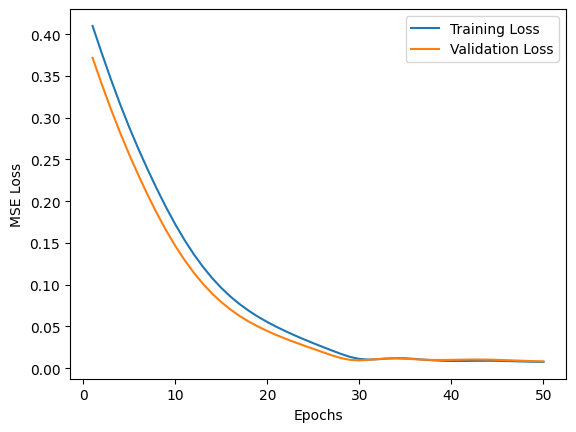

In [10]:
# Plotting the training curve
epochs=range(1,num_epochs+1)
st=0;end=50
plt.plot( epochs[st:end],train_losses[st:end], label='Training Loss')
plt.plot(epochs[st:end],valid_losses[st:end], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [11]:
torch.save(model.state_dict(),'./assets/trained models state/hybrid_bilstm_state.pt')